# BKT Processing

This notebook processed all data files (15 in total) and generate a CSV result file for each one. To understand how the processing works in detail, please refer to the `analysis/try_bkt.ipynb` notebook.

In [56]:
import pandas as pd
import re
import rich
import os

from pyBKT.models import Model


def _extract_chapter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract the data for the specified chapter
    """
    # Look for columns like responses_lo_1.1.level2
    # and extract out the chapter number e.g,. 1.1
    chapter_pattern = re.compile(r"responses_lo_(\d+\.\d+)\.level2")

    # Find column from data.columns that match the above pattern and extract out the chapter
    match = [chapter_pattern.match(c) for c in df.columns]
    chapter = [m.group(1) for m in match if m is not None][0]
    return chapter


def process_data(path: str, output_folder: str) -> pd.DataFrame:
    """
    Process the data from the file specified by the path
    """

    data = pd.read_csv(path, index_col=0, low_memory=False)
    chapter = _extract_chapter(data)

    rich.print(f"[yellow bold]Processing chapter: [/yellow bold]{chapter}")

    if len(data) == 0:
        rich.print("[red bold]No data found, skipped[/red bold]")
        return

    # Define the columns we're interested in
    points_earned_col = f"responses_lo_{chapter}.points_earned"
    submitted_col = f"responses_lo_{chapter}.dt_submitted"
    student_id_col = f"responses_lo_{chapter}.student_id"

    # Run some transformations to get the data into the correct format
    # Drop nan values in the responses_lo_2.3.points_earned column
    data = data.dropna(subset=[points_earned_col])

    # Ensure the dt_submitted column is in datetime format
    data[submitted_col] = pd.to_datetime(data[submitted_col])

    # Sort the data by student and submission time to create order_id
    data = data.sort_values(by=[student_id_col, submitted_col])

    # Create order_id (sequence number of observations per student)
    data["order_id"] = data.groupby(student_id_col).cumcount() + 1

    # Rename columns to match pyBKT expected format
    bkt_data = data.rename(
        columns={
            student_id_col: "user_id",
            points_earned_col: "correct",
        }
    )

    # Assign a skill name (you can change this if you're tracking multiple skills)
    bkt_data["skill_name"] = (
        0  # If you're tracking only one skill, this can be constant
    )

    # Drop unnecessary columns
    bkt_data = bkt_data[["user_id", "order_id", "correct", "skill_name"]]

    if len(bkt_data) == 0:
        rich.print("[red bold]No BKT data built, skipped[/red bold]")
        return

    # Fit the model
    model = Model(seed=42, num_fits=1)
    model.fit(data=bkt_data)

    # Generate predictions for each attempt
    predictions = model.predict(data=bkt_data)

    # Get the final predictions after all attempts for each student
    final_predictions = predictions.groupby("user_id").last()[
        ["correct_predictions", "state_predictions"]
    ]

    # Rename the aggregated columns
    final_predictions = final_predictions.rename(
        columns={
            "state_predictions": "final_state_predictions",
            "correct_predictions": "final_correct_predictions",
        }
    )

    # Create the folder if it doesn't exist using python
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    final_predictions.to_csv(f"{output_folder}/predictions_{chapter}.csv")

In [57]:
import os
import glob

DATA_ROOT = "../data/csv_oct09_24"
OUTPUT_ROOT = "./output/" + DATA_ROOT.split("/")[-1]

csv_files = glob.glob(os.path.join(DATA_ROOT, "*.csv"))

In [58]:
csv_files

['../data/csv_oct09_24/sample_sep_8.csv',
 '../data/csv_oct09_24/sample_sep_9.csv',
 '../data/csv_oct09_24/sample_sep_10.csv',
 '../data/csv_oct09_24/sample_sep_11.csv',
 '../data/csv_oct09_24/sample_sep_13.csv',
 '../data/csv_oct09_24/sample_sep_12.csv',
 '../data/csv_oct09_24/sample_sep_15.csv',
 '../data/csv_oct09_24/sample_sep_14.csv',
 '../data/csv_oct09_24/sample_sep_4.csv',
 '../data/csv_oct09_24/sample_sep_5.csv',
 '../data/csv_oct09_24/sample_sep_7.csv',
 '../data/csv_oct09_24/sample_sep_6.csv',
 '../data/csv_oct09_24/sample_sep_2.csv',
 '../data/csv_oct09_24/sample_sep_3.csv',
 '../data/csv_oct09_24/sample_sep_1.csv']

In [59]:
for csv_file in csv_files:
    process_data(csv_file, OUTPUT_ROOT)

rich.print("[green bold]Done![/green bold]")

Processing chapter: 3.3

Processing chapter: 3.4

Processing chapter: 3.2

Processing chapter: 3.6

Processing chapter: 3.5

Processing chapter: 4.3

Processing chapter: 4.2

No data found, skipped

Processing chapter: 4.1

No data found, skipped

Processing chapter: 1.1

Processing chapter: 2.3

Processing chapter: 3.1

Processing chapter: 2.1

Processing chapter: 1.3

No BKT data built, skipped

Processing chapter: 2.2

Processing chapter: 1.2

Done!

# Plot

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Literal

%config InlineBackend.figure_format = 'retina'

sns.set_theme("notebook")

def plot_histograms(column: Literal["final_state_predictions", "final_correct_predictions"]):
    """
    Plot the histogram of the final state predictions or final correct predictions.
    For each output_dfs, plot a histogram as a subplot.
    """

    output_files = sorted(glob.glob(f"{OUTPUT_ROOT}/*.csv"))
    output_dfs = [pd.read_csv(f) for f in output_files] 

    # Setup subplots, at most 4 subplots per row
    num_plots = len(output_dfs)
    num_rows = (num_plots + 3) // 4
    num_cols = min(num_plots, 4)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

    for i, (f, df) in enumerate(zip(output_files, output_dfs)):
        row = i // 4
        col = i % 4
        ax = axs[row, col] if num_rows > 1 else axs[col]
        sns.histplot(df[column], ax=ax, bins=20)
        chapter = re.search(r"predictions_(\d+\.\d+).csv", f).group(1)
        ax.set_title(f"Chapter {chapter}")
    
    
    fig.suptitle(f"Histogram of {column}", fontsize=18)
    fig.tight_layout()

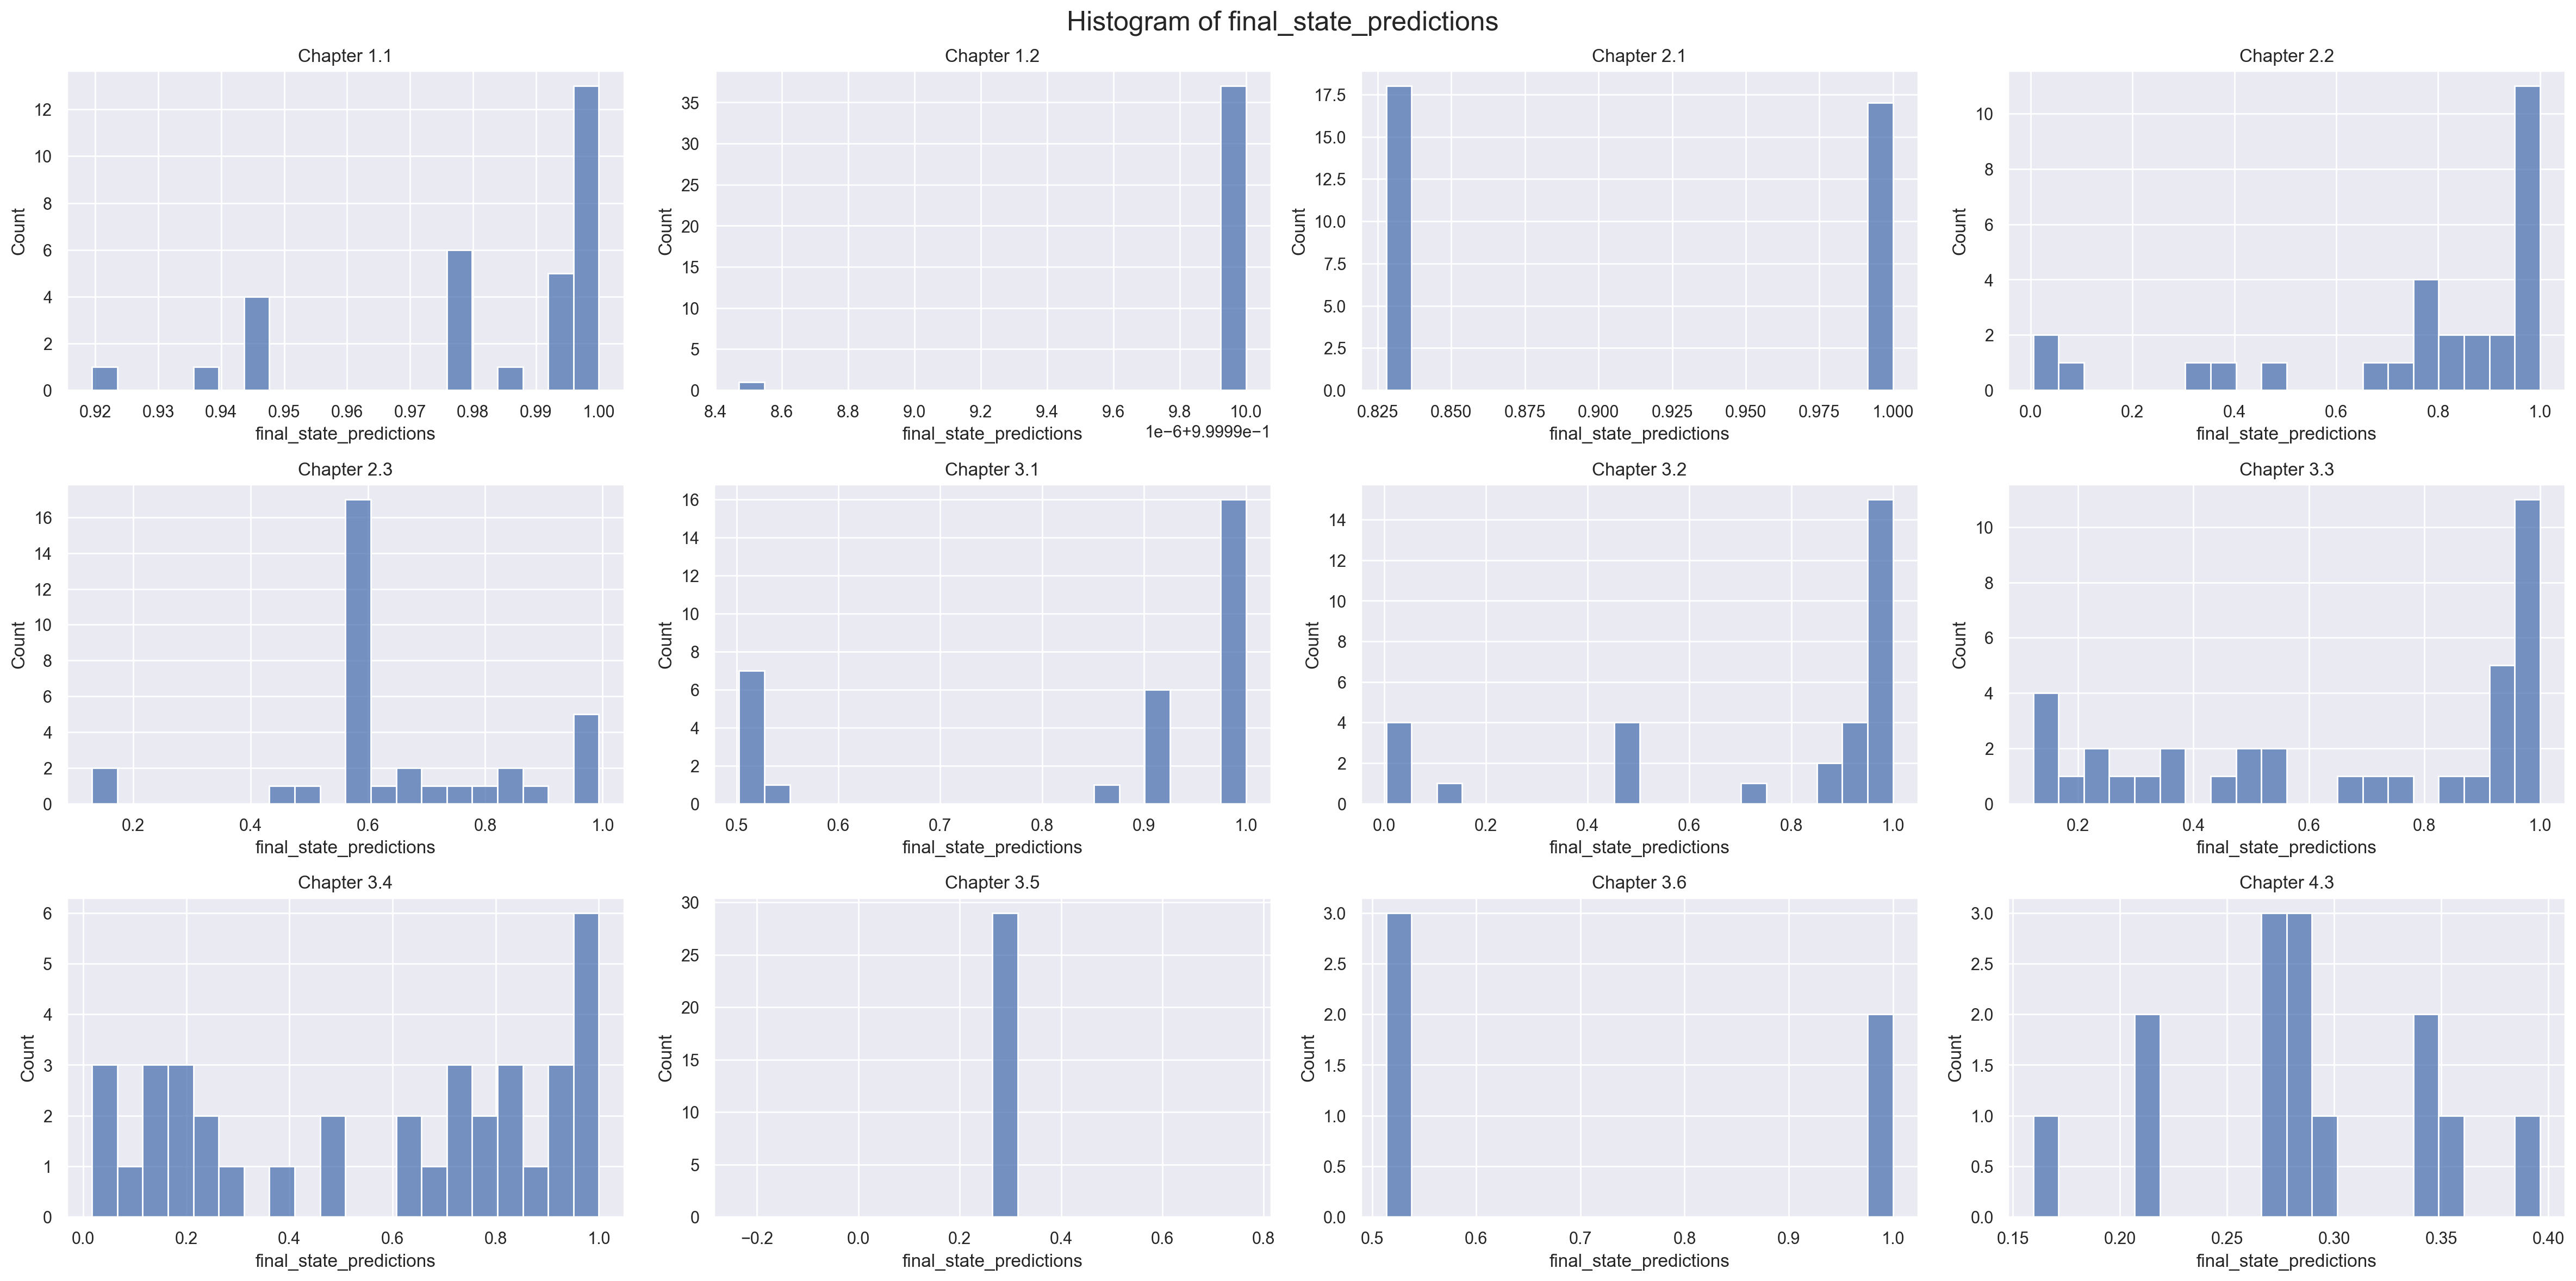

In [61]:
plot_histograms("final_state_predictions")

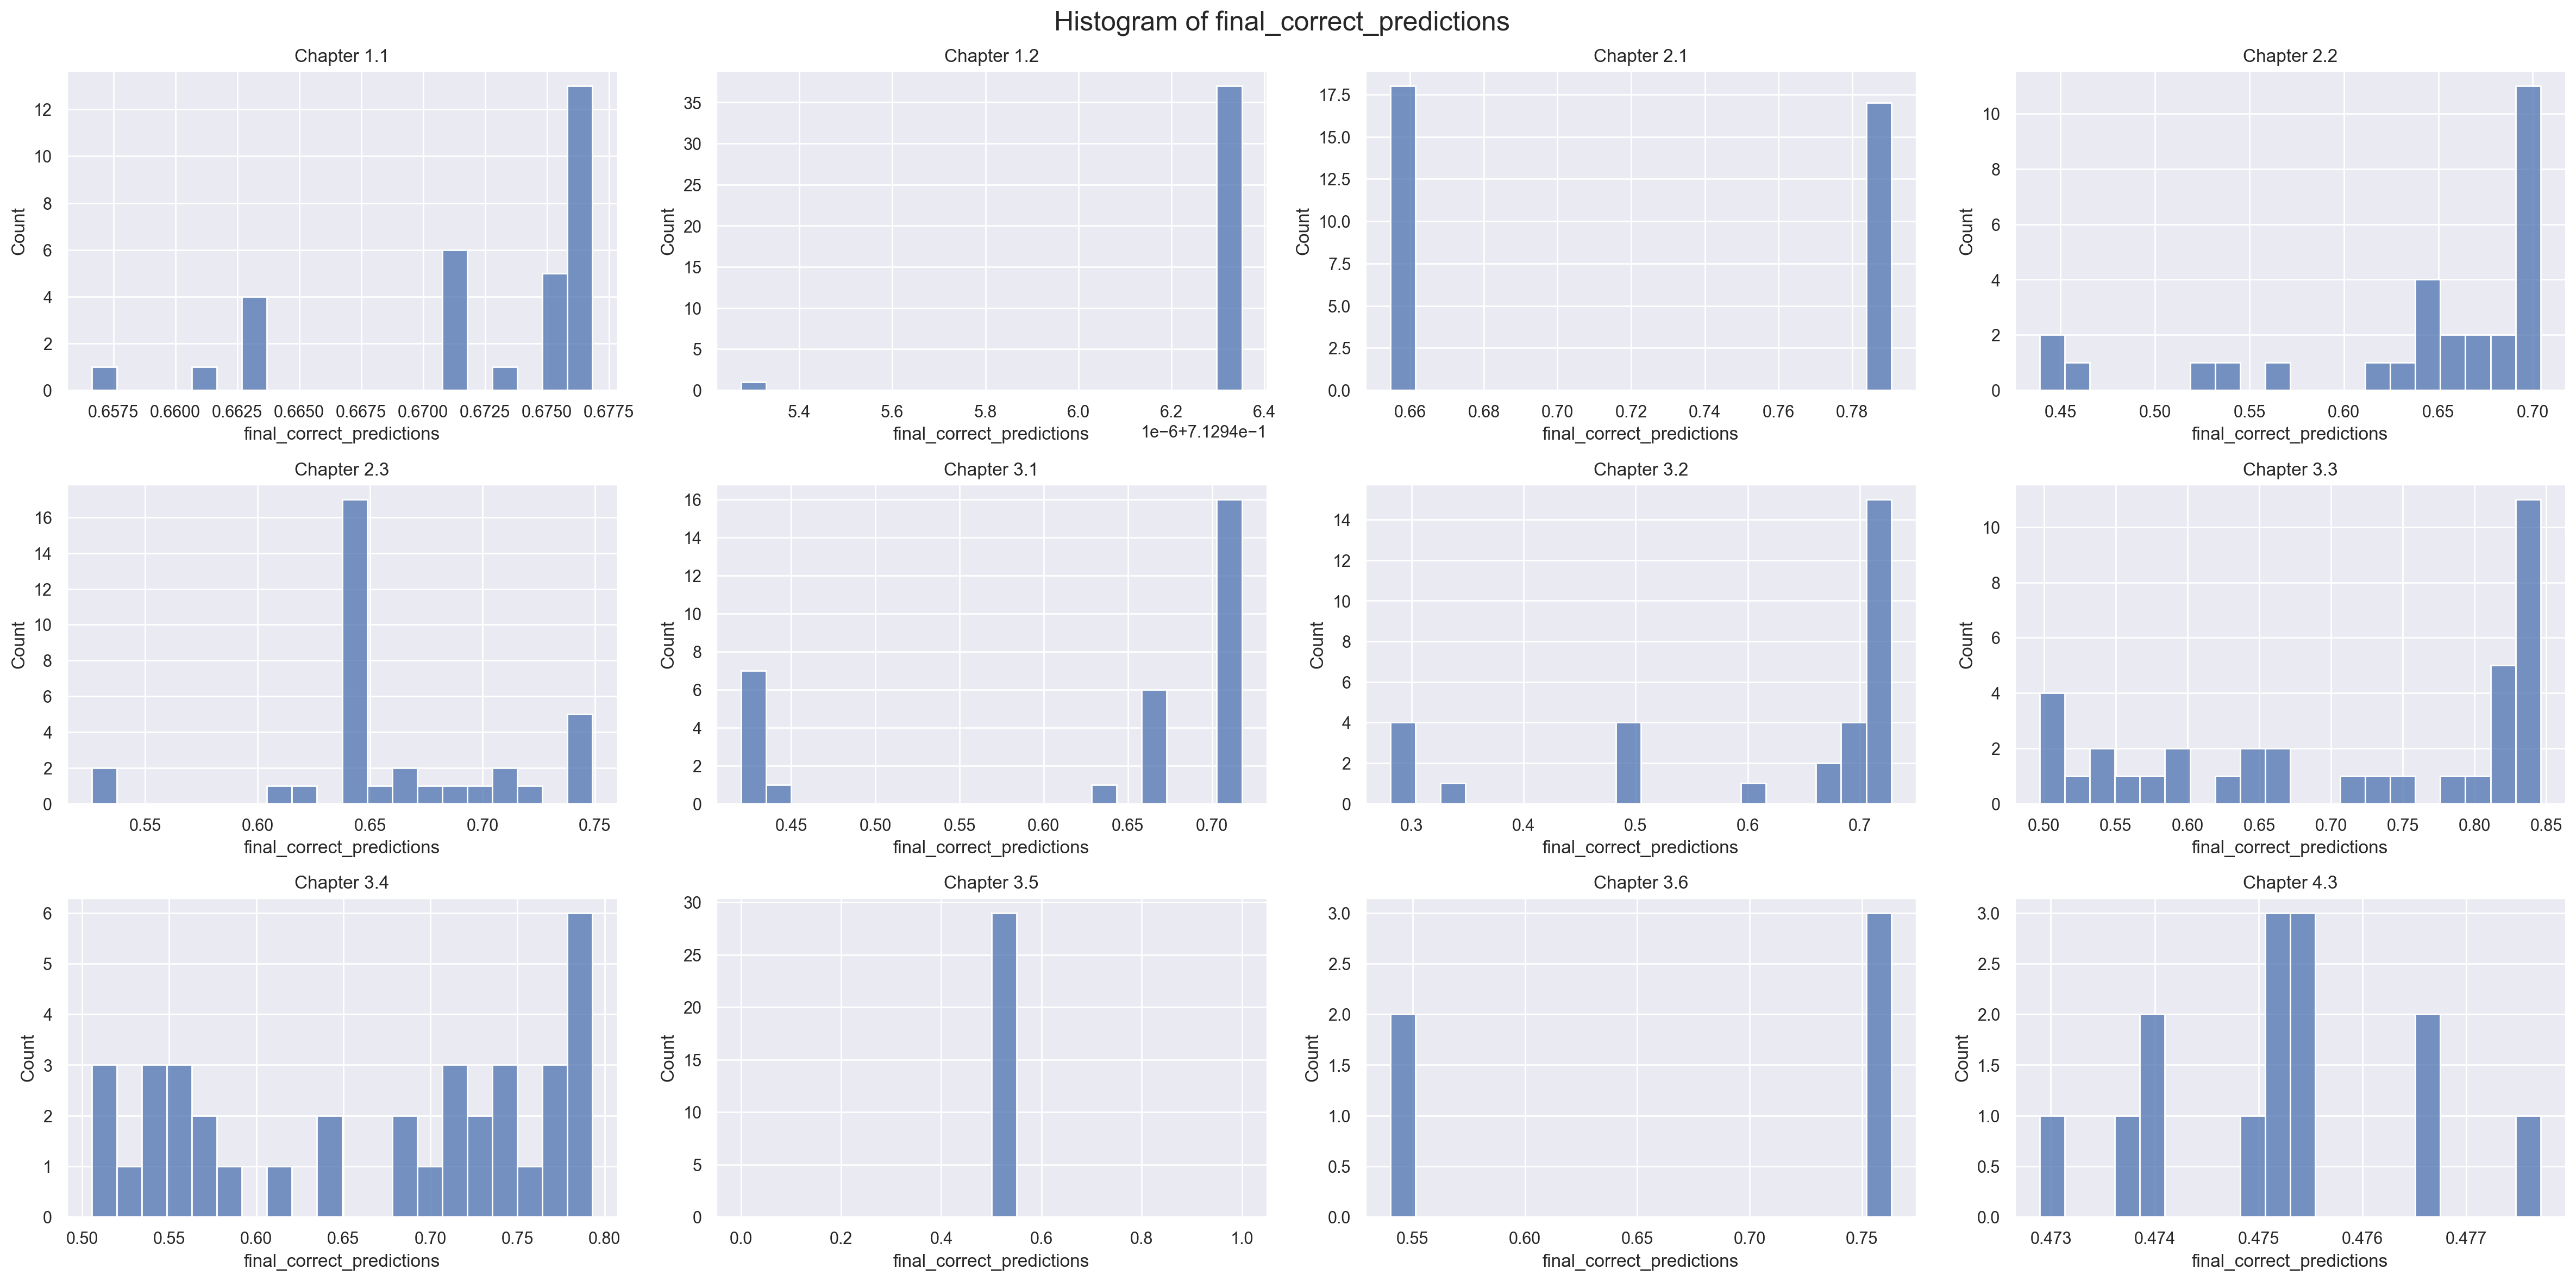

In [62]:
plot_histograms("final_correct_predictions")